In [1]:
import os, sys, time

sys.path
sys.path.append('./')

import numpy as np
from astropy import wcs
from astropy.io import fits

import matplotlib
matplotlib.use('PDF')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
# import aplpy

import nbimporter
import function as func
import gausspyAna as gp

In [102]:
class spectraAna:
    '''
    Class for analyzing image cube. The main purpose of this analysis is to
    stack the un-redshifted/blueshifted spectra.
    
    '''
    
    ### Constructor and destructor
    def __init__(self, fitscubename = ' '):
        self.fitscubename = fitscubename
    
    def __def__(self):
        pass
    
    
    ##function

    ### Methods in this class
    def readfits(self, verbose = False):
        '''
        The task to read the FITS image cube to memory.
        '''
        if verbose == True:
            print('This is the program to read FITS image cube')
            
        if self.fitscubename != ' ':
            if verbose == True:
                print('Reading FITS image cube :' + self.fitscubename)
        
        
        # import FITS image to HDU
        self.Ihdu = fits.open(fitscubename)
        
        # choose the certain information
        self.header = self.Ihdu[0].header
        self.naxis1 = self.Ihdu[0].header['naxis1']
        self.naxis2 = self.Ihdu[0].header['naxis2']
        self.naxis3 = self.Ihdu[0].header['naxis3']
        self.crpix3 = self.Ihdu[0].header['crpix3']
        self.cdelt3 = self.Ihdu[0].header['cdelt3']
        self.crval3 = self.Ihdu[0].header['crval3']
        self.ctype3 = self.Ihdu[0].header['ctype3']
        self.restfreq = self.Ihdu[0].header['RESTFREQ']
        self.cube = self.Ihdu[0].data
        
        
        
        
    def get_velocity(self, verbose = False,if_plot=False):
        '''
        The task to fit centroid frequency pixel-by-pixel.
        
        Input:
        freq_array [1D numpy array] : 
        intensity_array [1D numpy array] : 
        
        Return:
        
        '''
        if verbose == True: 
            print('Fitting centroid frequencies')
            
        
        if_plot = if_plot
            
        centroid_freq = func.fit_1dgaus(freq_array/1e9, intensity_array, plot=if_plot) 
        
        return centroid_freq

                 
     
    def unrbshift_spectra(self, verbose = False, 
                          #freq_array = np.array([]), 
                          intensity_array = np.array([]),
                          velocity_array = np.array([]),
                          rest_freq= 2.15219259E+11,
                          centroid_freq = 0, centroid_velo = 0, 
                          plot = False ):
        '''
        
        This function is to un-redshift/blueshift spectra
        
        '''
        if verbose == True:
            print('Unredshifting/unblueshifting spectra')

        rest_freq     = 2.15219259E+11  # rest frequency
        c             = 299792458         # the speed of light
        
        # Doppler effect
        #delta_freq = centroid_freq * 1e9 - rest_freq 
        #shift_freq = freq_array - delta_freq
        
        shift_velocity = velocity_array - centroid_velo * 1e3
        
        # plot the shifted spectra
        if plot == True:
            #func.plot_spectra( 
            #                    shift_freq /1e9, intensity_array , 
            #                    xlabel = 'shift freqency[GHz]',
            #                    datalabel='TBD'
            #                 )
        
            func.plot_spectra( shift_velocity/1e3, intensity_array, 
                                xlabel = 'shift velocity[km/s]'
                                 )
    
        return shift_velocity
        #return shift_freq
        
       
    
    def stack_spectra(self, verbose = False):
        '''
        The task to stack the unredshifted/unblueshifted spectra and plot the stacked spectra
        '''
        
        if verbose == True:
            print('Stacking the unredshifted/unblueshifted spectra')

        #figsize = figsize
            
        stacked_intensity = np.stack(intensity_list, axis=0)
        sum_intensity     = np.sum(stacked_intensity, axis=0)
        #print(sum_intensity)
        #print(sum_intensity[2])

        func.plot_spectra(shift_freq/1e9 , sum_intensity,
                          outPDF_filename = 'stacked_spectra.pdf')
        
        return sum_intensity

In [103]:
############ Major flow of data analysis ###############################

## Open FITS image cube
fitscubename = '/home/tcc/data/CH3OCHO.fits'
myAnalysis = spectraAna(fitscubename = fitscubename)
myAnalysis.readfits(verbose = False)

naxis1     = myAnalysis.naxis1
naxis2     = myAnalysis.naxis2
ctype3     = myAnalysis.ctype3
naxis3     = myAnalysis.naxis3
crpix3     = myAnalysis.crpix3
cdelt3     = myAnalysis.cdelt3
crval3     = myAnalysis.crval3 
restfreq   = myAnalysis.restfreq
cube       = myAnalysis.cube

## Create the frequency array based on the third axis
if ctype3 == 'VELO-LSR':
    velocity_array = np.zeros( naxis3 )
    velocity_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3
    
    c = 299792458
    freq_array = restfreq * (1 - velocity_array / c)

elif cytpe3 == 'FREQ':
    freq_array = np.zeros( naxis3 )
    freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3



## Fitting with `curve_fit`

In [90]:
## Read the intensity array 
intensity_list = []
for xpix in range(203,205):
    for ypix in range(268,270):
        intensity_array = myAnalysis.Ihdu[0].data[0][:, ypix, xpix]
        
        if not np.any( np.isnan(intensity_array) ):
            x = xpix
            y = ypix
            intensity_list.append((x,y,intensity_array))
        
        else:
            print(f'Warning: Found NaN values in array at pixel ({xpix},{ypix})')


203 268


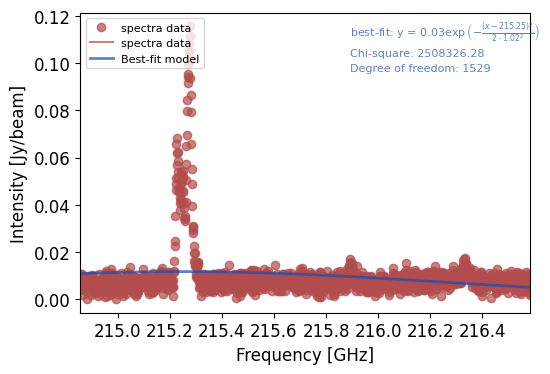

203 269


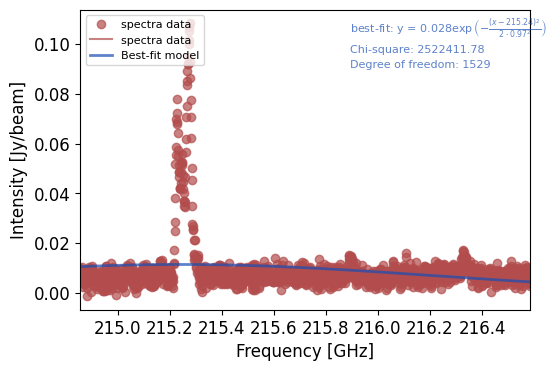

204 268


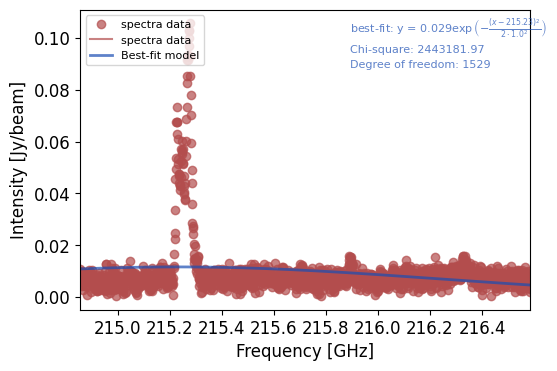

204 269


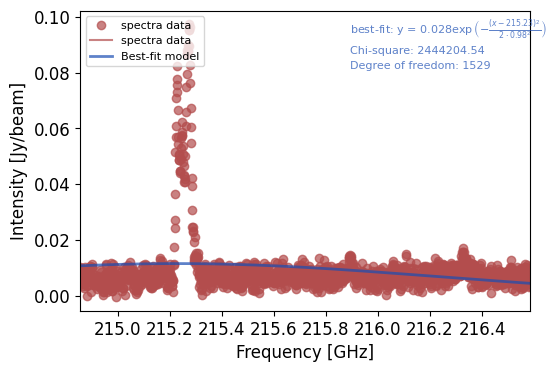

In [93]:
## To do the gaussian fitting 
filename = 'gaussian_err.log'
os.system('rm -rf '+ filename)
pixels_to_remove = []

with open(filename,'w') as f:
    
    for x, y, intensity_array in intensity_list:          
        
        try:
            print(x,y)
            centroid_freq = func.fit_1dgaus(freq_array/1e9, intensity_array, plot = True, kind = 'freq')
            centroid_velo = func.fit_1dgaus(freq_array = velocity_array/1e3, intensity_array = intensity_array, 
                                            plot = False, kind = 'velo',xlabel='Velocity[km/s]', y_err=0.0019585446)
            
            if np.isnan(centroid_freq):
                #raise ValueError(f'({x},{y})Centroid frequency is NaN')
                write_string = f'({x},{y})Centroid frequency is NaN\n'
                f.write(write_string)
                pixels_to_remove.append((x,y,intensity_array))
            
        except Exception as e:
            out_string = f'Pixels (i,j)= ({x},{y})' + ' failed in Gaussian fittings: {str(e)}\n'
            f.write(out_string)
            pixels_to_remove.append((x,y,intensity_array))
        
for pixel in pixels_to_remove:
    intensity_list.remove(pixel)
      

In [ ]:
## Unredshift/unblueshift
for x, y, intensity_array in intensity_list:
    try:
        shift_freq = myAnalysis.unrbshift_spectra(
                freq_array=freq_array, intensity_array=intensity_array, velocity_array=velocity_array,
                centroid_freq = centroid_freq,
                centroid_velo = centroid_velo,
                plot = True )

    except Exception as e:
        print(f'Error in pixel ({x},{y}): {str(e)}')

## Fitting with `gausspy algorithm`

In [104]:
RMS = 0.01
data   = {} #dict
errors = np.ones(cube.shape[1]) * RMS
#print(errors)
velo = velocity_array/1e3
freq = freq_array/1e9
#np.arange(cube.shape[1])

FILENAME_DATA_GAUSSPY = 'cube.pickle'

# cycle through each spectrum
for xpix in range(203,205):
    for ypix in range(268,270):

        # get the spectrum
        intensity = cube[0][:, ypix, xpix]
        #print(spectrum.shape)

        # get the spectrum location
        location = np.array((xpix, ypix))


        # Enter results into GaussPy-friendly dataset
        data['data_list'] = data.get('data_list', []) + [intensity]
        data['x_values']    = data.get('x_values', []) + [velo]
        data['errors']    = data.get('errors', [])   + [errors]
        data['location']  = data.get('location', []) + [location]

        
#print(data['errors'])
# Save decomposition information
pickle.dump(data, open(FILENAME_DATA_GAUSSPY, 'wb'))

In [105]:
FILENAME_DATA_GAUSSPY = 'cube.pickle'
FILENAME_DATA_DECOMP = 'cube_decomposed.pickle'

FILENAME_DATA_DECOMP = gp.decomposition(FILENAME_DATA_GAUSSPY)

using 3 out of 4 cpus
   ---->   0


  0%|                                               | 0.00/3.00 [00:00<?, ?it/s]

   ---->     ---->    21
   ---->  
 3


100%|████████████████████████████████████████| 3.00/3.00 [00:04<00:00, 1.64s/it]
3it [00:00, 38956.38it/s]

SUCCESS
100 finished.%


In [111]:
data_decomposed = pickle.load(open(FILENAME_DATA_DECOMP,'rb'))

intensity_list = []
for i in range(len(data_decomposed['means_fit'])):

    
    #print(data_decomposed['amplitudes_fit'][i])
    max_index = np.argmax(data_decomposed['amplitudes_fit'][i]) #Find the highest peak
    velo_fit = data_decomposed['means_fit'][i][max_index]

    intensity_array = data['data_list'][i]
    intensity_list.append(intensity_array)
    
    shift_velo = myAnalysis.unrbshift_spectra( intensity_array=intensity_array, 
                                               velocity_array=velocity_array,
                                               centroid_velo = velo_fit,
                                               plot = False )
    
    shift_freq = restfreq * (1 - shift_velo / c)
    #func.plot_spectra(shift_freq/1e9,intensity_array)
   

### Figures

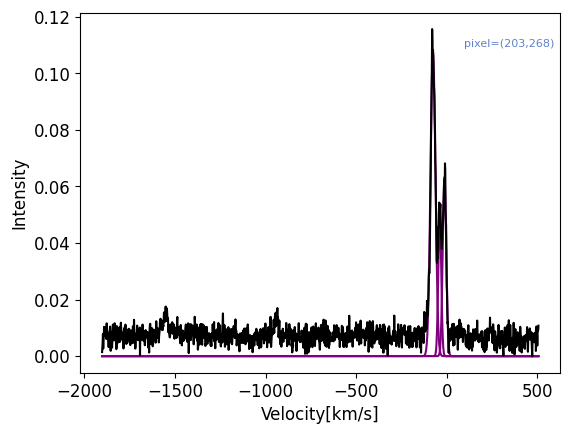

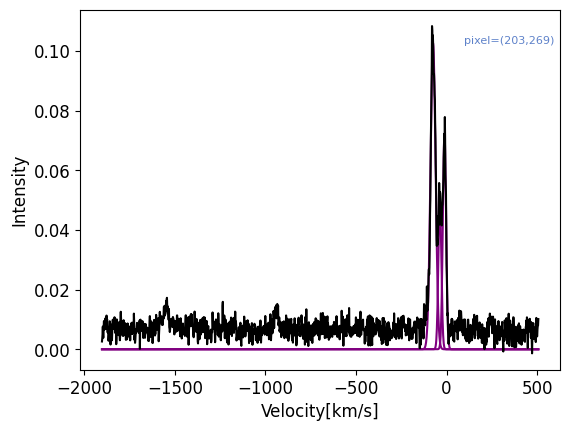

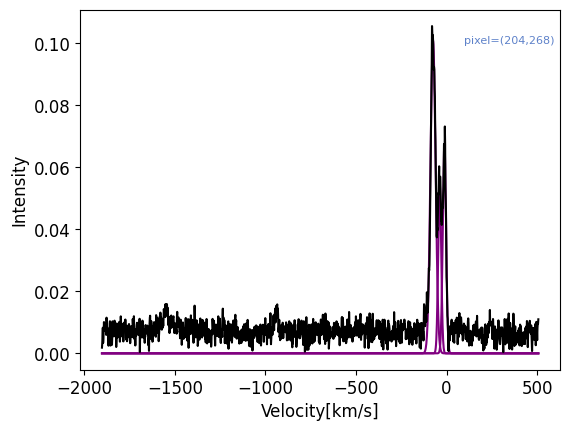

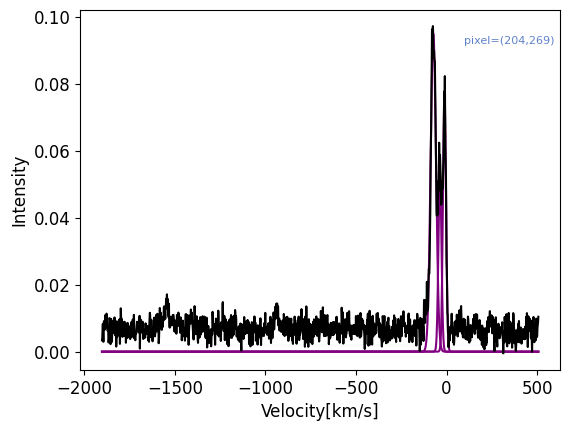

In [110]:
if_plot = True

if if_plot == True:
    for index in range(len(data_decomposed['means_fit'])):
        # original data
        x = data['x_values'][index]
        y = data['data_list'][index]
        pix = data['location'][index]
    
        # Fitting parameter
        fit_fwhms = data_decomposed['fwhms_fit'][index]
        fit_means = data_decomposed['means_fit'][index]
        fit_amps  = data_decomposed['amplitudes_fit'][index]
        #print(fit_means)
   
        fig = plt.figure()
        ax  = fig.add_axes([0.12, 0.1, 0.75, 0.75])
        
        if len(fit_amps) > 0.:
            for j in range(len(fit_amps)):
                amp, fwhm, mean =  fit_amps[j], fit_fwhms[j], fit_means[j]
                yy = amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)
                plt.plot(x,yy,'-',lw=1.5,color='purple')
    
        plt.plot(x, y, color='black')
        #ax.set_xlim(0,1532)
        plt.xlabel('Velocity[km/s]')
        plt.ylabel('Intensity')
    
        xpix = pix[0]
        ypix = pix[1]
        label_string = f'pixel=({xpix},{ypix})'
    
        plt.text(0.8, 0.9, # location of the text label
                 label_string, # content of the label
                 color = (0.1, 0.3, 0.7, 0.7),
                 verticalalignment = 'bottom', horizontalalignment = 'left',
                 transform = ax.transAxes, # use relative coordinates
                 fontsize = 8)
    
        outPDF_filename = f'decomposed({xpix},{ypix}).pdf'
        plt.savefig(outPDF_filename, transparent=True)
        plt.show()

# Stacking spectra

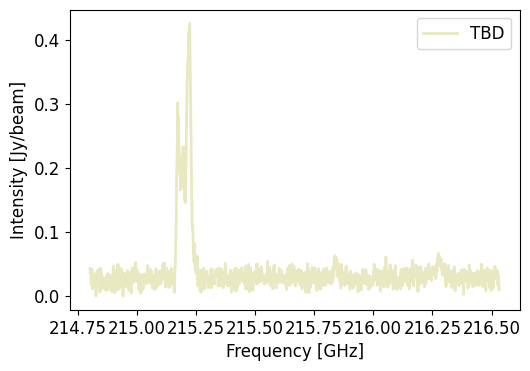

In [112]:
## Stack the spectra and plot it
sum_intensity = myAnalysis.stack_spectra(verbose = False)

## Plot the specific frequency range

693 782


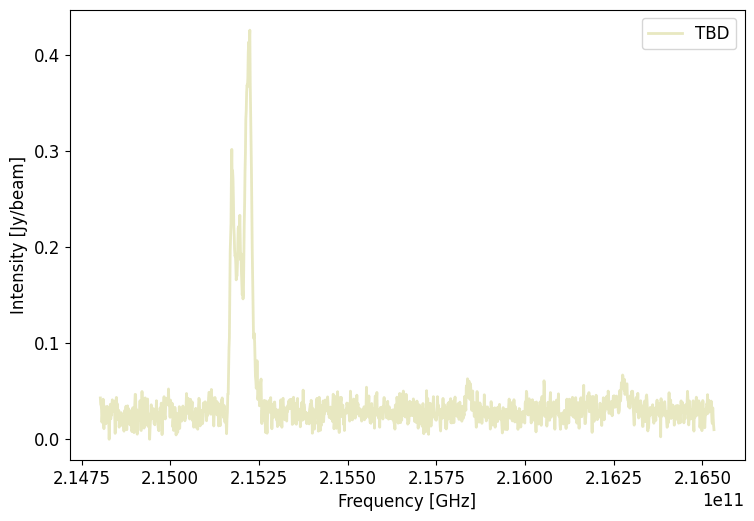

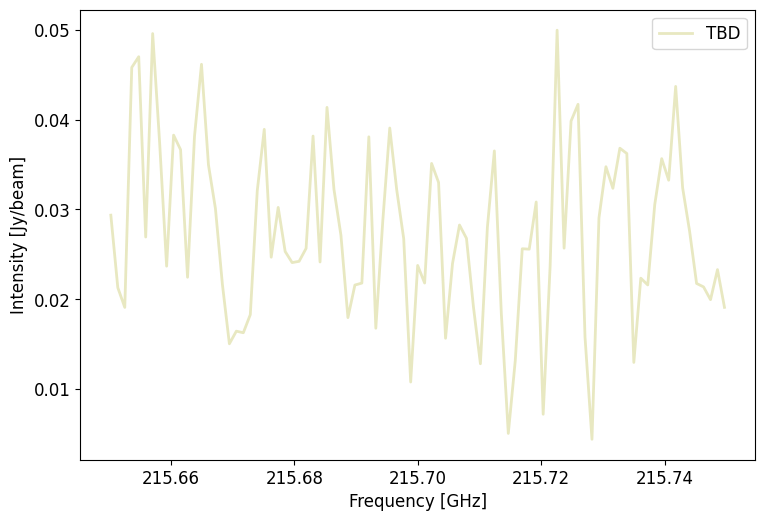

In [115]:
freqGHz_start = 215.65
freqGHz_end   = 215.75

#print(shift_freq/1e9)

freq_startpix = np.searchsorted(-shift_freq, -freqGHz_end*1e9) #due to the descending array
freq_endpix   = np.searchsorted(-shift_freq, -freqGHz_start*1e9)

func.plot_spectra(shift_freq,sum_intensity,figsize=(9,6))

print(freq_startpix, freq_endpix)

sliced_freq = shift_freq[freq_startpix:freq_endpix]/1e9
sliced_intensity = sum_intensity[freq_startpix:freq_endpix]

func.plot_spectra(sliced_freq, sliced_intensity,figsize=(9,6))
